# FRB Pipeline Simulation

In [1]:
%matplotlib notebook
import numpy as np
from matplotlib.pyplot import *

In [2]:

def axis_labels(x, y, z):
    xlab = xlabel(x)
    ylab = ylabel(y)
    titles = title(z)
    legends = legend
    return xlab, ylab, titles, legends

In [3]:
#Define the parameters for the noise that will be mixed with the pulse
Cf = 1400e6 #This is the centre frequency in MHz, and where we will be viewing from
Bw = 10e6 #This is the bandwidth that we are observing with our telescope
fs_rf = 12e9 # Frequency running simulation at.
period = .005 #seconds 

In [4]:
#Define the timescale in which we will be observing
t = np.linspace(-.0025,.0025, period*fs_rf) #Decreasing the period for this will decrease the samples obtained

/home/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [5]:
#Create the Gaussian noise profile for the pulsar
length = len(t)     #This defines the number of timesamples we have, ie the number of samples collected
mu = 0              #This indicates an offset of 0, meaning the signal is perfetly centred about 0
sigma = 1           #This idicates an std of 1
gnoise = np.random.normal(mu, sigma, length) #This is the GAussian noise for the signal
pw = .0004 #seconds
print(length)

60000000


In [6]:
gnoise = np.exp(.5*-(t/pw)**2)*gnoise #Define the pulse of the signal. The gaussian profile takes an input of the 

In [7]:
gnoise.shape

(60000000,)

<IPython.core.display.Javascript object>


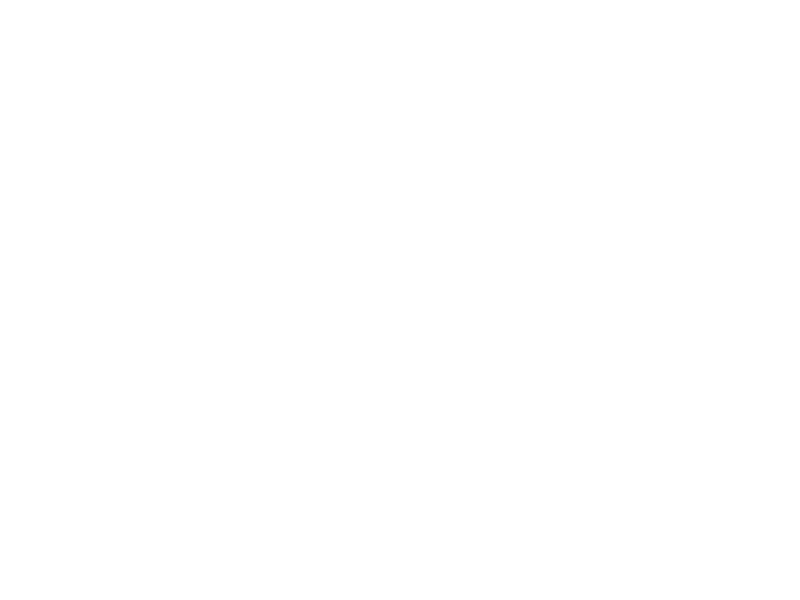

/home/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


(Text(0.5,0,'time(s)'),
 Text(0,0.5,'value(unitless)'),
 Text(0.5,1,'Gaussian noise pulse'),
 <function matplotlib.pyplot.legend(*args, **kwargs)>)

In [8]:
#Now plot the signal, and observe the pulse shape. To see the pulse without destroying the computer, 
#plot every 10000th point
figure()
plot(np.linspace(0,.005, period*fs_rf)[0::10000],gnoise[0::10000], ls='none', marker='.')
axis_labels('time(s)', 'value(unitless)', 'Gaussian noise pulse')

In [9]:
#Now take the fourier transform of the pulse to get it in frequency space
fourier_pulse = np.fft.fft(gnoise)

In [10]:
#The fourier transformed data should look like broadband noise, so define the axes properly before plotting
broad_freq = np.fft.fftfreq(length, 1/(fs_rf/1e6)) #This gives the signal in MHz, (specifically from the 1e6)

In [11]:
broad_freq

array([ 0.    ,  0.0002,  0.0004, ..., -0.0006, -0.0004, -0.0002])

<IPython.core.display.Javascript object>


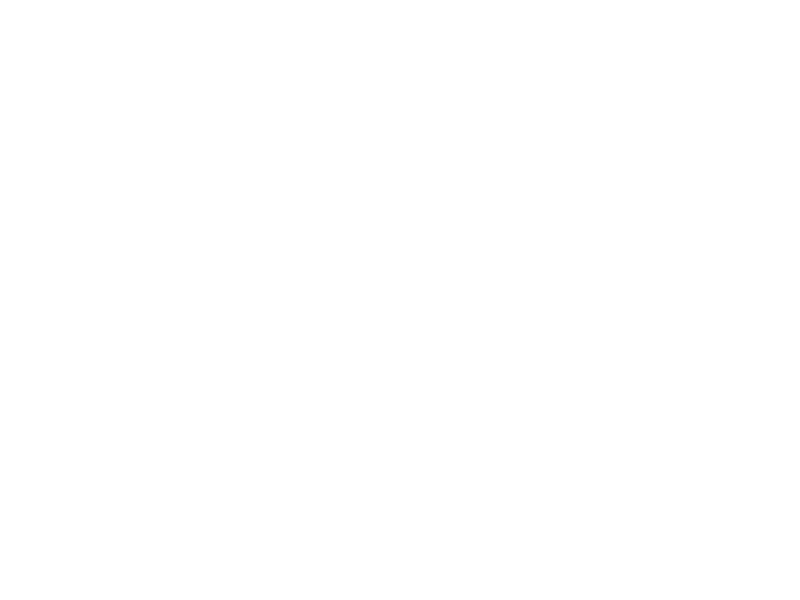

(Text(0.5,0,'frequency(MHz)'),
 Text(0,0.5,'amplitude(unitless)'),
 Text(0.5,1,'Fourier transformed  gaussian pulse'),
 <function matplotlib.pyplot.legend(*args, **kwargs)>)

In [12]:
figure()
plot(broad_freq[::1000], np.abs(fourier_pulse[::1000])) #Square the abs value to get better view
axis_labels("frequency(MHz)", 'amplitude(unitless)', 'Fourier transformed  gaussian pulse')

In [13]:
#Now we modify the noise, so that there are only +- of the same frequency in it of it. This is the pulsar!
#Everything outside the two reference frequencies is turned to zero
highpass_freq = (Cf-Bw/2.0) #This sets the centre frequency to 0, with a bandwidth deifned above
highpass_index1 = int(highpass_freq/(fs_rf/2)*length/2) #This finds the point in the array with the value
highpass_index2 = length - highpass_index1 #Same but for different point
fourier_pulse[:highpass_index1] = 0 #This is turning everything outside the two points to zero
fourier_pulse[highpass_index2:] = 0 #Same as above

#Everything outside of the two frequencies is turned to 0
nyquest_index = int(length/2) #This value is determined by the nyquist sampling theorem(helps figure out where the chinkc are)
#The following is the same as above, but now for outside the frequency values
lowpass_freq = Cf+Bw/2.0 
lowpass_index1 = int(lowpass_freq/(fs_rf/2)*length/2)
lowpass_index2 = length - lowpass_index1
fourier_pulse[lowpass_index1:nyquest_index] = 0
fourier_pulse[nyquest_index:lowpass_index2] = 0

<IPython.core.display.Javascript object>


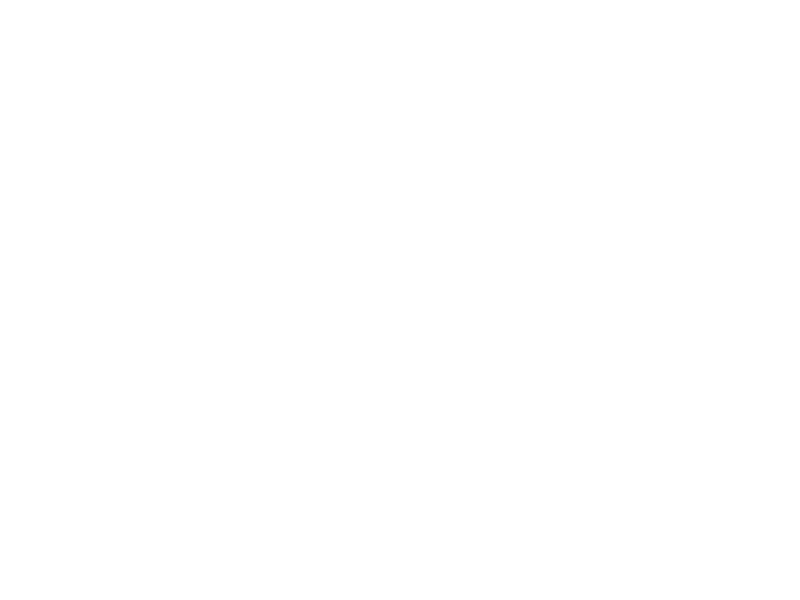

(Text(0.5,0,'frequency(MHz)'),
 Text(0,0.5,'amplitude(unitless)'),
 Text(0.5,1,'Newly created pulsar'),
 <function matplotlib.pyplot.legend(*args, **kwargs)>)

In [14]:
figure()
plot(broad_freq[::1000], np.abs(fourier_pulse[::1000]))
axis_labels("frequency(MHz)", 'amplitude(unitless)', 'Newly created pulsar')

In [15]:
#Now turn the pulsar back into time space from frequency space
blimited_pulse = np.fft.ifft(fourier_pulse)


<IPython.core.display.Javascript object>


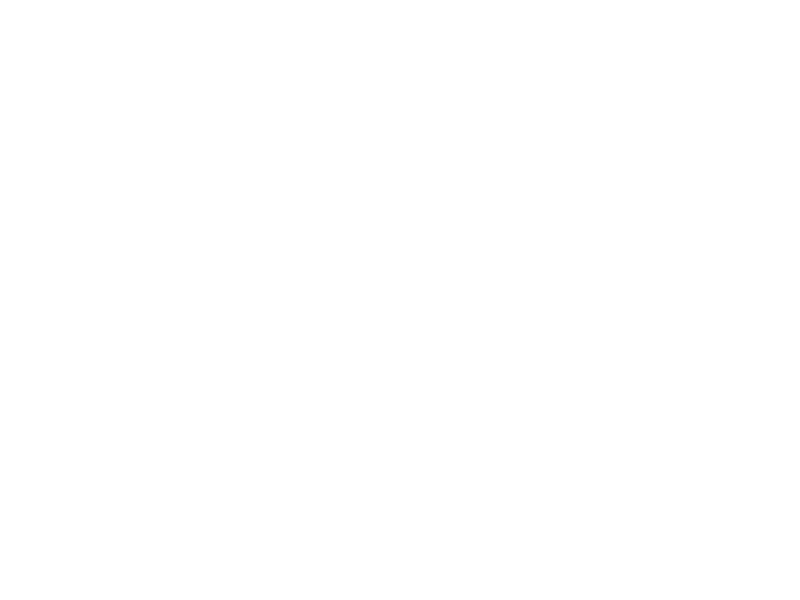

/home/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/andy/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(Text(0.5,0,'time(s)'),
 Text(0,0.5,'value(unitless)'),
 Text(0.5,1,'Pulsar wave packet'),
 <function matplotlib.pyplot.legend(*args, **kwargs)>)

In [16]:
#If this pulse is plotted again, it sill looks like the same as before
figure()
plot(np.linspace(0,.005, period*fs_rf)[0::10000], blimited_pulse[::10000])
axis_labels('time(s)', 'value(unitless)', 'Pulsar wave packet')

In [17]:
#Now need to create the mixing signal:
mixing_signal = np.exp(-2.00j*np.pi* Cf/fs_rf *np.arange(length)) #With this we create the mixing signal using the euler equation for the signal

#We assume the pulse is always centred around the same point, so the only part of the signal equaiton needed is 
#omega*t. 

In [18]:

#Mix and sample down the pusar signal so that we can have an I Q data set for the bandwidth
mixed_down_s = blimited_pulse*mixing_signal
N_cutoff = int(Bw/2/fs_rf*length) #This is from the lowpass fileter definition
fmixed = np.fft.fft(mixed_down_s) #This creates the fourier transform of the mixed signal
fmixed[N_cutoff:-N_cutoff] = 0.0 # this makes it so that the imaginary magnitudes are comparable to the reals. This is
                                    #also our filter
filtered_mixed_down_s = np.fft.ifft(fmixed) #This brings the fourier space pulse back into a packet
#Downsample so that is...
downsampled_filtered_mixed_down_s = filtered_mixed_down_s[::int(fs_rf/(Bw))]
#complex sampled at 10MHz instead of 12GHz
#This gives us 50000 indicies instead of 60000000

<IPython.core.display.Javascript object>


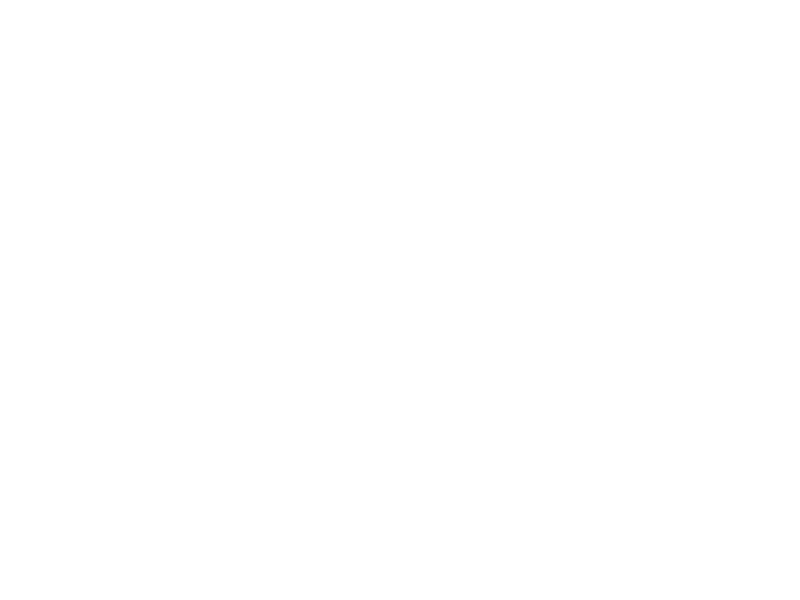

(Text(0.5,0,'Time(s)'),
 Text(0,0.5,'Amplitude'),
 Text(0.5,1,'Downsampled Pulsar'),
 <function matplotlib.pyplot.legend(*args, **kwargs)>)

In [19]:
#The simulation can be run from this point

# Use gaussian noise, filter with same time width.
#Now plot the signal, and observe that the pulse shape is the same, but now using smaller increments between samples
figure()
plot(np.linspace(0,.005, len(downsampled_filtered_mixed_down_s))[0::100], downsampled_filtered_mixed_down_s[::100].real)
plot(np.linspace(0,.005, len(downsampled_filtered_mixed_down_s))[0::100], downsampled_filtered_mixed_down_s[::100].imag)
axis_labels('Time(s)', 'Amplitude', 'Downsampled Pulsar')

In [20]:
#We repeat the pulse to get about 0.15 seconds of data
downsampled_filtered_mixed_down_s_repeated = np.tile(downsampled_filtered_mixed_down_s, 30)

In [21]:
#This is where the pulsar is dispersed
#We do a convolution in fourier space, which must be long wrt the dispersion delay time
dis_length = len(downsampled_filtered_mixed_down_s_repeated) #This gives us the number of time samples of the 
                                                             #downsampled repeated pulse
freq_step = np.linspace(-Bw/2, Bw/2, dis_length) #This is the new frequency step for the pulse
DM = 600 #This is the dispersion measure and it is completely arbitrary
#Create the signal to be convolved with the data. This signal is the pulsar
H = np.exp(2j*np.pi*4.15e15*DM*freq_step**2/((Cf+freq_step)*Cf**2)) #Where the part that looks similar to the delay 
#time is the 'time' portion of the equation

In [22]:
#Check how long the dispersion is
delay_time = 4.15e15 * (1/(Cf-Bw/2)**2 - 1/(Cf+Bw/2)**2) * DM
#The delay time must be significantly less than the dispersion of the data
print(delay_time) #This time must be less thah H

0.018149151032241222


In [23]:
dispersed_downsampled_filtered_mixed_sig = np.fft.ifft(np.fft.fft(downsampled_filtered_mixed_down_s_repeated)*np.fft.fftshift(H))
#The pulse signal and the dispersion of the pulse were convolved to give a dispersed pulse

<IPython.core.display.Javascript object>


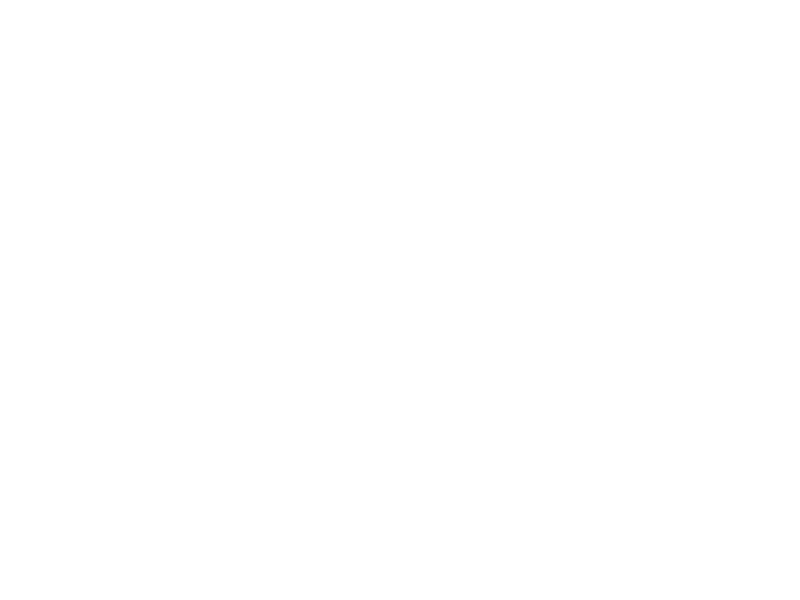

(Text(0.5,0,'time(s)'),
 Text(0,0.5,'Amplitude'),
 Text(0.5,1,'Dispersed downsampled mixed pulsar'),
 <function matplotlib.pyplot.legend(*args, **kwargs)>)

In [24]:
#Plotting the convolved signal...
figure()
plot(np.linspace(0,.15, dis_length)[::100], dispersed_downsampled_filtered_mixed_sig[::100].real)
plot(np.linspace(0,.15, dis_length)[::100], dispersed_downsampled_filtered_mixed_sig[::100].imag)
axis_labels('time(s)', 'Amplitude', 'Dispersed downsampled mixed pulsar')

In [25]:
#now that we have the pulse, we proceed to take the fourier transform of it, to graphically show 
#that we have created what we expected. This is step two in the flowgraph on Gnu
        

In [26]:
#We want to show how the amplitude of the pulse changes with respect to frequency and time. Currently, we can only 
#show either or

In [27]:
#We want to intergrate to 0.1ms since this is sgnifiantly less than 5ms
nfreq = 400                                                #This is an educated, but arbitrary choice for the parameter
print(len(dispersed_downsampled_filtered_mixed_sig)/nfreq) #This gives us the frequency channels we are using

3750.0


In [28]:
#We want a 10Msps, since this is the bandwidth
times = 1/10e6

In [49]:
len(dispersed_downsampled_filtered_mixed_sig)

1500000

In [89]:

#To check that this number of frequencies, integrations, and sampling rate work
#integrate 5 samples
step = 400 #This comes from the number of frequency channels desired
integration_size = int(2e-4/(times)/nfreq) #This comes from the 0.2ms integration that we desire. It is .2 bc .1 was too small
n_time = int(len(dispersed_downsampled_filtered_mixed_sig)/step/integration_size) #This finds the number of
                                                            #timesteps
rec_spect = np.zeros(((n_spectra), step), dtype=complex) #This the is the recieved 3d plot of frequency vs time
for i in range(n_time): #This is the number of 'rows'
    for j in range(integration_size):
        spect = np.fft.fft(dispersed_downsampled_filtered_mixed_sig[(integration_size*i+j)*step : (integration_size*i+j+1)*step])
        #This is an easy way to get the row size that we desire
        rec_spect[i] += spect*spect.conjugate() #The first timestep of the frequencies needs to be multiplied by its conjugate
        #The spetra are added together because we are 'folding' the amplitudes together. If we don't, then there appears 
        #a jump in the data.

        
        
    

In [195]:
n_frequencies = np.fft.fftfreq(n_time, 1/(10e6/1e6)) #This is the number of frequency channles. This will lable the 
                                                     #the x axis
pulse_freqs = np.fft.fftshift(n_frequencies)+Cf/1e6 #This will place the centre frequency of the plot at 1400MHz
dispersed = np.flip(np.transpose(np.fft.fftshift(abs(rec_spect))), 0)#The array of the data must be flipped to match 
                                    #the units in the plot,and it must be transposed so that time is on the x axis.

In [196]:
dispersed.shape

(400, 750)

<IPython.core.display.Javascript object>


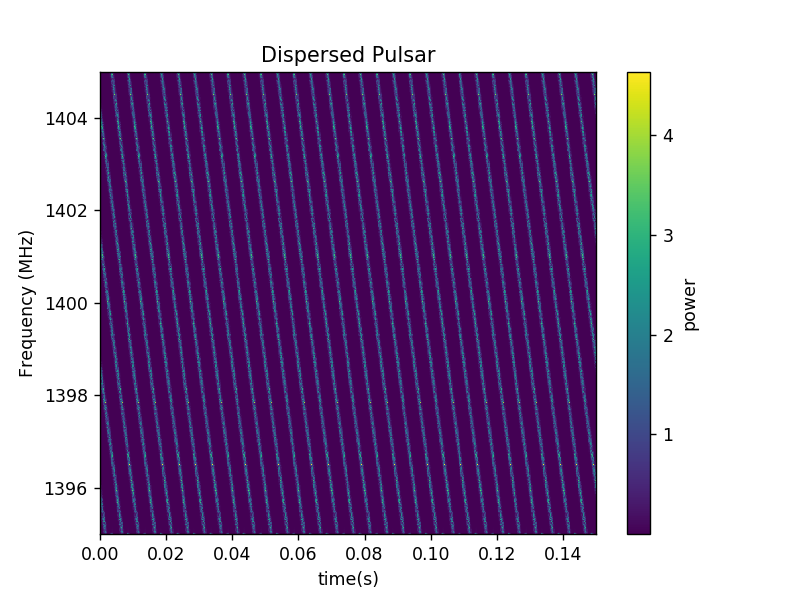

In [250]:
#This is the graph of the pulsar, where we can see that it is dispersed
figure()
imshow(dispersed, extent=[np.amin(np.linspace(0,.15, dis_length)),\
                            np.amax(np.linspace(0,.15, dis_length)),\
                            np.amin(pulse_freqs),\
                            np.amax(pulse_freqs)],\
                              aspect='auto')
axis_labels('time(s)','Frequency (MHz)',  'Dispersed Pulsar')
colorbar(label = 'power')

#Congrats!, we now have a dispersed pulsar


In [141]:
#Define the time shoft in seconds of the dispersion
time_change = t1s+4.15e6*DM*((1/(Cf-pulse_freqs[i]/2)**2 - 1/(Cf+pulse_freqs[i]/2)**2))

In [275]:
dedisperse = (dispersed*0)
for i in range(n_time):
    dedisperse[:,i] = np.roll(dispersed[:,i],int(time_change[i]))
dedisperse.shape

(400, 750)

<IPython.core.display.Javascript object>


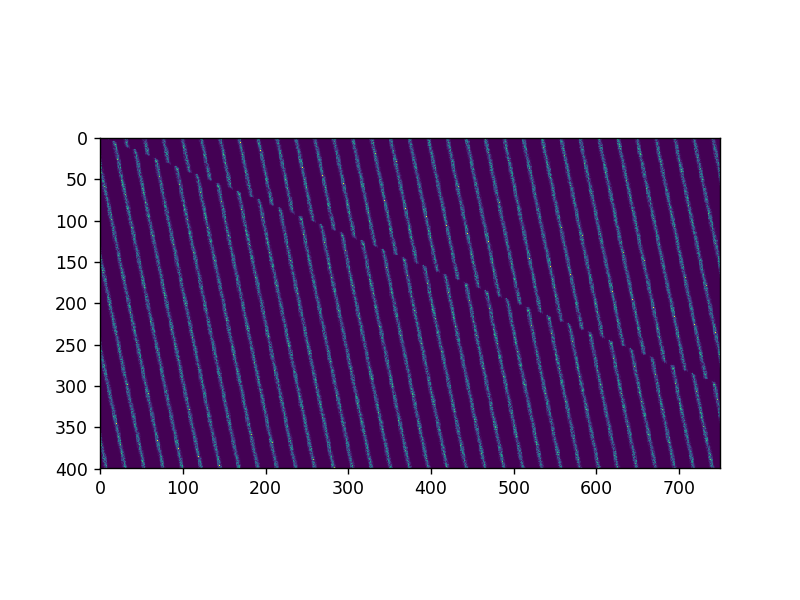

In [276]:
figure()
imshow(abs(dedisperse))

In [277]:
DM

600

In [ ]:
#Now we need to dedisperse the pulse. Assume for now that we don't know the DM for the pulsar. 
#Need the time that one frequency arrives vs another


In [ ]:
#Once dedispersed, and find the DMs. All the dms should be the same here.
fft_pulse = np.fft.fft(abs(rec_spect), axis=1)
fft_pulse1 = np.fft.fft(abs(rec_spect), axis=0)


In [ ]:
#To do coherent dedispersion, we should convolve the FFT of the dispersion time with the dedispersed pulse
DMs = np.arange(1,401)
t_fourier = Cf * DMs
fit = np.fft.fft(t_fourier)

ty = fit*rec_spect



In [ ]:
#Find the period first before folding the pulse, cause we have to

In [ ]:
figure()
imshow(abs(fft_pulse1))
#figure()
#imshow(abs(fft_pulse2))

In [ ]:
sums = np.sum(((fft_pulse)), axis=1)

In [ ]:
.15/25
